In [ ]:
# Part 1
!pip install librosa scikit-learn torch torchaudio --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 839.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
import random

# Fix seed for reproducibility
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [ ]:
# Synthetic Audio Generator
def create_signal(label_type, sr=16000, duration=1.2):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    if label_type == 0:  # bonafide
        wave = np.sin(2 * np.pi * 300 * t) + 0.5 * np.sin(2 * np.pi * 600 * t)
        wave += 0.1 * np.random.randn(len(t))
    else:  # deepfake
        wave = np.sin(2 * np.pi * 300 * t + np.pi/4)
        wave += 0.5 * np.sin(2 * np.pi * 700 * t + np.pi/6)
        wave += 0.4 * np.random.randn(len(t))
    return wave / np.max(np.abs(wave)), sr

def build_dataset(total_samples=400):
    signals, labels = [], []
    for i in range(total_samples):
        lbl = i % 2
        audio, sr = create_signal(lbl)
        signals.append({'audio': audio, 'rate': sr})
        labels.append(lbl)
    return signals, labels

train_data, train_labels = build_dataset(400)
test_data, test_labels = build_dataset(100)

print("✅ Synthetic samples generated.")


✅ Synthetic samples generated.


In [5]:
# Extracting Audio Features
def extract_mfcc_features(audio_list, label_list, n_mfcc=20, max_frames=80):
    features, targets = [], []

    for audio_obj, lbl in zip(audio_list, label_list):
        mfcc = librosa.feature.mfcc(y=audio_obj['audio'], sr=audio_obj['rate'], n_mfcc=n_mfcc)
        if mfcc.shape[1] < max_frames:
            mfcc = np.pad(mfcc, ((0, 0), (0, max_frames - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :max_frames]

        features.append(mfcc.flatten())
        targets.append(lbl)

    return np.array(features), np.array(targets)

X_train, y_train = extract_mfcc_features(train_data, train_labels)
X_test, y_test = extract_mfcc_features(test_data, test_labels)
print(f"Feature matrix: {X_train.shape}")


Feature matrix: (400, 1600)


In [6]:
# Training Traditional Models
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Perceptron": Perceptron(max_iter=1000)
}

for model_name, model in models.items():
    print(f"\n🔹 Training {model_name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else preds
    print(classification_report(y_test, preds))
    print(f"AUC-ROC: {roc_auc_score(y_test, probs):.4f}")



🔹 Training LogReg
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

AUC-ROC: 1.0000

🔹 Training SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

AUC-ROC: 1.0000

🔹 Training Perceptron
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00     

In [7]:
# Defining PyTorch Dataset
class AudioSet(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.y)

train_loader = DataLoader(AudioSet(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(AudioSet(X_test, y_test), batch_size=32)


In [8]:
# Building and Training DNN
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.layers(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SimpleDNN(X_train.shape[1]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("🔁 Training DNN...")
for epoch in range(8):
    net.train()
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = net(Xb)
        loss = loss_fn(outputs, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


🔁 Training DNN...
Epoch 1 | Loss: 0.0000
Epoch 2 | Loss: 0.0000
Epoch 3 | Loss: 0.0000
Epoch 4 | Loss: 0.0000
Epoch 5 | Loss: 0.0000
Epoch 6 | Loss: 0.0000
Epoch 7 | Loss: 0.0000
Epoch 8 | Loss: 0.0000


In [9]:
# Evaluating DNN
net.eval()
preds, probs = [], []

with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(device)
        outputs = net(Xb)
        pred = torch.argmax(outputs, dim=1).cpu().numpy()
        prob = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds.extend(pred)
        probs.extend(prob)

print("\n📊 DNN Classification Results")
print(classification_report(y_test, preds))
print(f"AUC-ROC: {roc_auc_score(y_test, probs):.4f}")



📊 DNN Classification Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

AUC-ROC: 1.0000


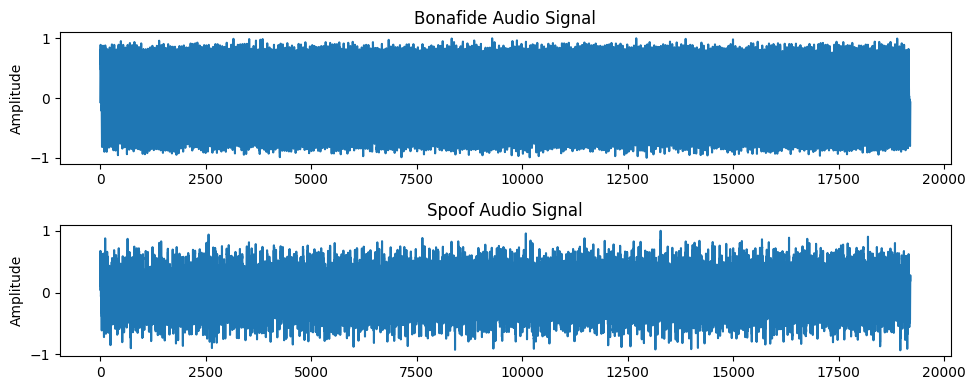

In [10]:
# Visualizing Waveforms of Synthetic Audio
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 4))

axs[0].plot(train_data[0]['audio'])
axs[0].set_title("Bonafide Audio Signal")
axs[0].set_ylabel("Amplitude")

axs[1].plot(train_data[1]['audio'])
axs[1].set_title("Spoof Audio Signal")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


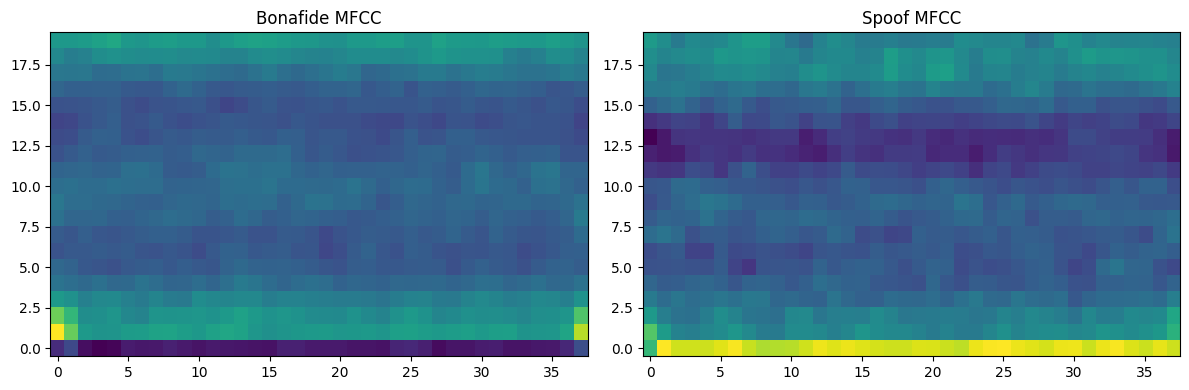

In [12]:
# MFCC Spectrograms
mfcc_bona = librosa.feature.mfcc(y=train_data[0]['audio'], sr=train_data[0]['rate'], n_mfcc=20)
mfcc_spoof = librosa.feature.mfcc(y=train_data[1]['audio'], sr=train_data[1]['rate'], n_mfcc=20)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(mfcc_bona, aspect='auto', origin='lower')
axs[0].set_title("Bonafide MFCC")

axs[1].imshow(mfcc_spoof, aspect='auto', origin='lower')
axs[1].set_title("Spoof MFCC")

plt.tight_layout()
plt.show()


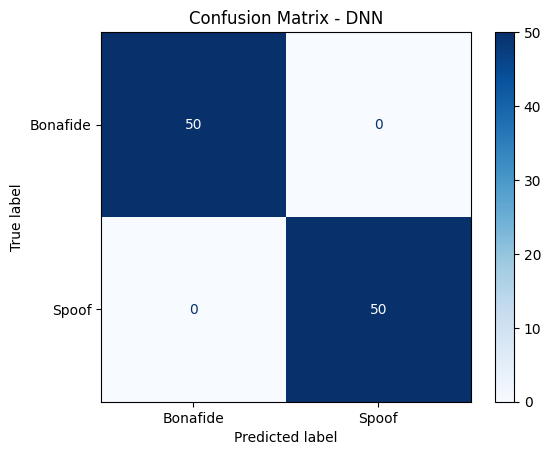

In [14]:
#  Confusion Matrix for DNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bonafide", "Spoof"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - DNN")
plt.show()


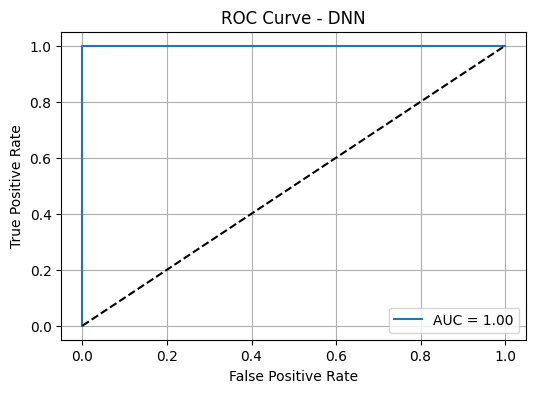

In [15]:
# ROC Curve for DNN
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, probs):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DNN")
plt.legend()
plt.grid()
plt.show()
